In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
num_rep = 10
th_scaling = 10000
plot_colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [3]:
def get_throughput(latency, graph_size, th_scaling=10000000000):
  return graph_size  * th_scaling / float(latency) / 1000

In [4]:
def read_fault(file_name):
    workers = []
    throughput_all_fault = []
    throughput = []
    times = []
    fault_rate = []
    graph_size = 150
    with open(file_name, "r") as in_file:
        for l in in_file:
            if l.startswith('END'):
                break
            if l.startswith('===='):
                for t in times:
                    throughput.append([get_throughput(x, graph_size) for x in t])
                throughput_all_fault.append(throughput)
                throughput = []
                times = []
                continue
            elif l.startswith("worker spec,"):
                r = l.split(',')[2][0:-2]
                fault_rate.append(float(r))
            elif l.startswith("failure"): 
                fault_rate.append(float(l.split(',')[1]))
            elif l.startswith('[') or l.startswith(' {['):
                line = l.strip(" {}[],\n")
                line = line.replace("]", "")
                line = line.replace(" ", "")
                data = line.split(",")
                if not int(data[-1]) in workers:
                    workers.append(int(data[-1]))
                times.append(data[0: -1])
    return (throughput_all_fault, workers, fault_rate, graph_size)

In [5]:
throughput_all_fault, workers, fault_rate, graph_size = read_fault('../results/tc150_straggle_LATE.txt')

In [6]:
def plot(throughput, workers, ax, lbl, c):
    # confidence interval
    max_throughputs = [np.max(t) for t in throughput]
    min_throughputs = [np.min(t) for t in throughput]
    mean_throughputs = [np.mean(t) for t in throughput]
    err = [np.std(t) for t in throughput]

    # create flattened version
    workers_flat = np.array([[w] * num_rep for w in workers]).flatten()
    throughput_flat = throughput.flatten()

    ax.scatter(workers_flat, throughput_flat, s=6, alpha=0.8, color=c)
    ax.fill_between(workers, min_throughputs, max_throughputs, alpha=0.3, color=c)
    ax.errorbar(workers, mean_throughputs, yerr=err, label=lbl, color = c)


In [7]:
def plot_all(throughput_all, workers, graph_size, fault_rate):
  fig, ax = plt.subplots()
  fig.set_size_inches(7,5)
  ax.set_title(f"Throughput with schedulers and stragglers")
  ax.set_xlabel("Number of workers")
  ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.set_ylabel("Throughput")
  for i, throughput in enumerate(throughput_all):
    global foo
    plot(np.array(throughput), np.array(workers), ax, f"fault rate {fault_rate[i]}", plot_colours[i])
  ax.legend()


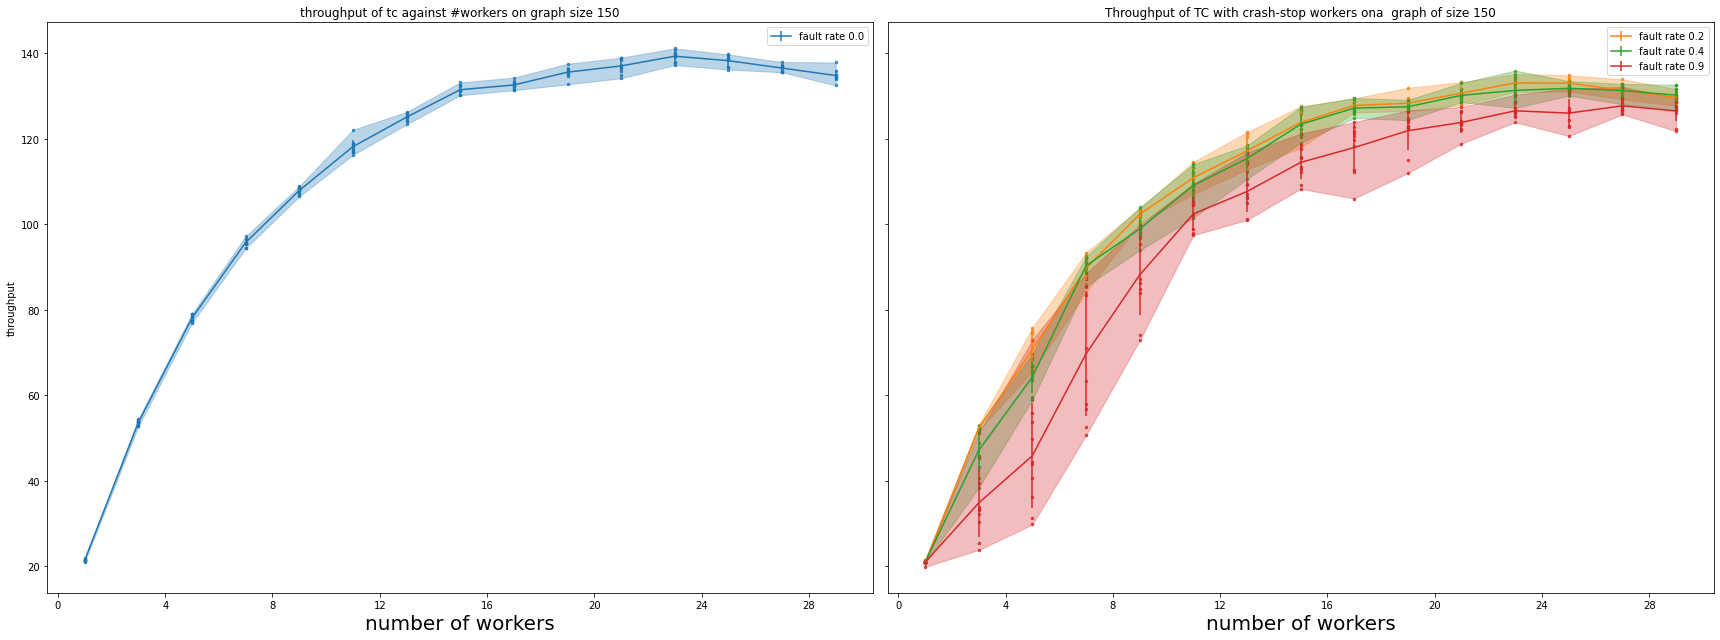

In [8]:
throughput_all_fault, workers, fault_rate, graph_size = read_fault('../results/tc150_straggle.txt')

throughput_all = np.array(throughput_all_fault)[[0]]
fault_rate = np.array(fault_rate)[[0]] 

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(24, 9)
ax[0].set_title(f"throughput of tc against #workers on graph size {graph_size}")
ax[0].set_xlabel("number of workers", fontsize=20)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax[0].set_ylabel("throughput")
for i, throughput in enumerate(throughput_all):
  plot(np.array(throughput), np.array(workers), ax[0], f"fault rate {fault_rate[i]}", plot_colours[i])
ax[0].legend()


throughput_all_fault, workers, fault_rate, graph_size = read_fault('../results/tc150_fail.txt')

throughput_all = np.array(throughput_all_fault)[[2,4,9]]
fault_rate = np.array(fault_rate)[[2,4,9]]
ax[1].set_title(f"Throughput of TC with crash-stop workers ona  graph of size {graph_size}")
ax[1].set_xlabel("number of workers", fontsize=20)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
for i, throughput in enumerate(throughput_all):
  plot(np.array(throughput), np.array(workers), ax[1], f"fault rate {fault_rate[i]}", plot_colours[i+1])
ax[1].legend()

fig.tight_layout()
fig.savefig('tc150_fail.pdf')

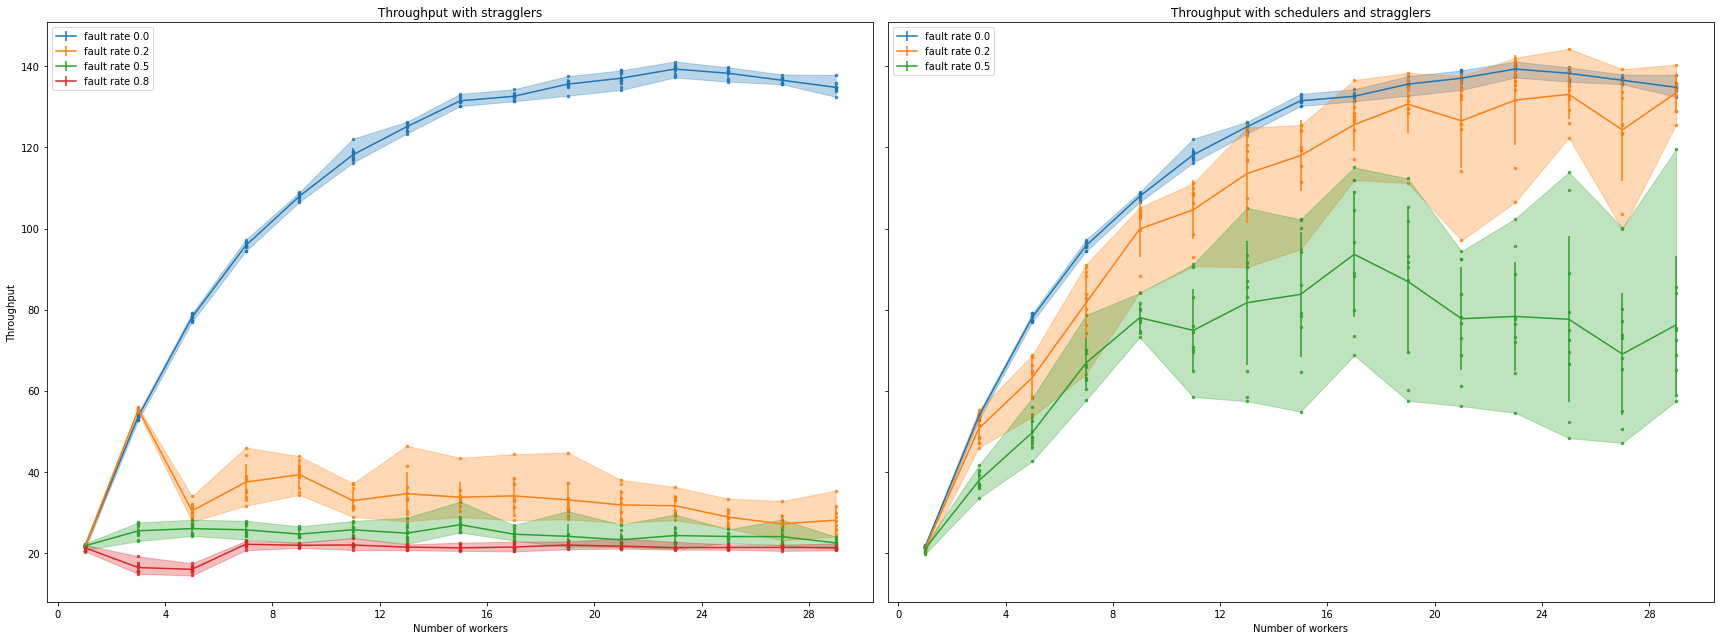

In [9]:
throughput_all_fault, workers, fault_rate, graph_size = read_fault('../results/tc150_straggle.txt')

throughput_all = np.array(throughput_all_fault)
fault_rate = np.array(fault_rate)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(24, 9)
ax[0].set_title(f"Throughput with stragglers")
ax[0].set_xlabel("Number of workers")
ax[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax[0].set_ylabel("Throughput")
for i, throughput in enumerate(throughput_all):
  plot(np.array(throughput), np.array(workers), ax[0], f"fault rate {fault_rate[i]}", plot_colours[i])
ax[0].legend()


throughput_all_fault, workers, fault_rate, graph_size = read_fault('../results/tc150_straggle_LATE.txt')

throughput_all = np.array(throughput_all_fault)
fault_rate = np.array(fault_rate)
ax[1].set_title(f"Throughput with schedulers and stragglers")
ax[1].set_xlabel("Number of workers")
ax[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
for i, throughput in enumerate(throughput_all):
  plot(np.array(throughput), np.array(workers), ax[1], f"fault rate {fault_rate[i]}", plot_colours[i])
ax[1].legend()

fig.tight_layout()
fig.savefig('tc150_straggle.pdf')

In [10]:
def read_data2(file_name):
    workers = []
    throughput_all_input = []
    times = []
    graph_size = []
    with open(file_name, "r") as in_file:
        throughput = []
        for l in in_file:
            if l.startswith('END'):
              break
            if l.startswith('graph'):
                graph_size.append(int(l.split(' ')[2]))
            if l.startswith('[') or l.startswith(' {'):
              line = l.strip(" {}[],\n")
              line = line.replace("]", "")
              line = line.replace(" ", "")
              data = line.split(",")
              if not (int(data[-1])) in workers:
                workers.append(int(data[-1]))
              times.append(data[0: -1])
            if l.startswith('='):
                throughput = []
                for t in times:
                    throughput.append([get_throughput(x, graph_size[-1]) for x in t])
                throughput_all_input.append(throughput)
                times = []
                if l.startswith('END'):
                  break

    return (throughput_all_input, workers, graph_size)

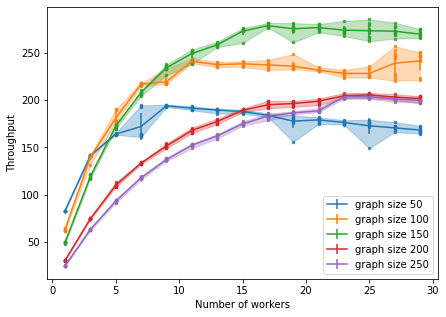

In [11]:
prog_name = 'pt'
(throughput_all_input, workers, graph_size) = read_data2(f'../results/{prog_name}_th.txt')

fig, ax = plt.subplots()
fig.set_size_inches((7,5))
for i,th in enumerate(throughput_all_input):
   plot(np.array(th), np.array(workers), ax, f"graph size {graph_size[i]}", plot_colours[i])

ax.legend()
# ax.set_title(f"{} throughput") 
ax.set_ylabel("Throughput")
ax.set_xlabel("Number of workers")

fig.savefig(f'{prog_name}_th.pdf')

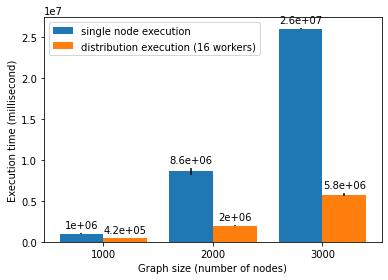

In [12]:
serial_times = np.array([[981683,924164,1096319,999730,985753], [8202526,8202526,9174541,8521315,8863537], [25952409, 26152862, 26045359,26045359,26045359]])

dist_times = np.array([[432210, 422397, 426536, 398916, 415008], [2109506,1926203,1942029,1946191,2003525],[5567576,5593760,6035319,5882689,5779305]])

# dist_times = np.array([[1882308,1887702,1999376], [10744950,10678793,10650090], [26077252, 24939219, 25980677]])
# souffle_times = np.array([[23398, 23271, 23154], [96678, 97704, 97247], [248578, 248841, 251002]])
in_mem_times = np.array([226581,238316,259334])




labels = ['1000', '2000', '3000']
serial_means = [np.mean(m) for m in serial_times]
dist_means = [np.mean(m) for m in dist_times]
in_mem_means = np.mean(in_mem_times)

serial_err = [np.std(m) for m in serial_times]
dist_err = [np.std(m) for m in dist_times]
in_mem_err = np.std(in_mem_times)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(5.5,4)
rects1 = ax.bar(x - width/2, serial_means, width, yerr = serial_err, label='single node execution')
rects2 = ax.bar(x+width/2, dist_means, width, yerr = dist_err, label='distribution execution (16 workers)')
# rects3 = ax.bar(x[0] + width, in_mem_means, width, yerr = in_mem_err, label='in-memory implementation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution time (millisecond)')
ax.set_xlabel('Graph size (number of nodes)')
# ax.set_title('Comparison of execution times of two engines for different graphs')

ax.set_xticks(x)
ax.set_xticklabels(['1000', '2000', '3000'])
ax.legend()

ax.bar_label(rects1, fmt="%.2g", padding=3)
ax.bar_label(rects2, fmt="%.2g", padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()
fig.savefig('baseline.pdf')

plt.show()


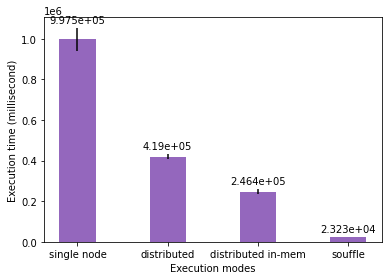

In [13]:
serial_times = np.array([981683,924164,1096319,999730,985753])
dist_times = np.array([432210, 422397, 426536, 398916, 415008])
in_mem_times = np.array([226581,238316,259334,257386, 250483])
souffle_times = np.array([23398, 23271, 23154, 23184, 23159])

serial_th = np.array([get_throughput(t, 1000) for t in serial_times])
dist_th = np.array([get_throughput(t, 1000) for t in dist_times])
in_mem_th = np.array([get_throughput(t, 1000) for t in in_mem_times])
souffle_th = np.array([get_throughput(t, 1000) for t in souffle_times])

mean_times = [np.mean(serial_times), np.mean(dist_times), np.mean(in_mem_times), np.mean(souffle_times)]
errs_times = [np.std(serial_times), np.std(dist_times), np.std(in_mem_times), np.std(souffle_times)]

mean_th = [np.mean(serial_th), np.mean(dist_th), np.mean(in_mem_th), np.mean(souffle_th)]

errs_th = [np.std(serial_th), np.std(dist_th), np.std(in_mem_th), np.std(souffle_th)]

labels = ['single node', 'distributed', 'distributed in-mem', 'souffle']

x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()
fig.set_size_inches(5.5,4)

rects = ax.bar(x, mean_times, yerr = errs_times, width=0.4, color='tab:purple')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Execution modes')
ax.set_ylabel('Execution time (millisecond)')
# ax.set_title('Execution time of TC in different modes on a graph of 1000 nodes', fontsize=15)

ax.bar_label(rects, fmt="%.4g", padding=3)

fig.tight_layout()
fig.savefig('baseline2.pdf')

plt.show()


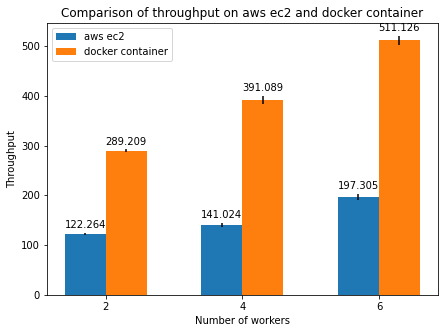

In [14]:
aws_two_workers = [12326549,12585455,11912530]
aws_four_workers = [10351394,10539947,11041840]
aws_six_workers = [7418178,7943928,7466887]

docker_two_workers = [5266476,5137644,5157419]
docker_four_workers = [3753316,3808110,3950223]
docker_six_workers = [2953722,2865040,2988098]

graph_size = 150

num_workers = [2,4, 6]

aws_two_th = np.array([graph_size * th_scaling / (t / 1000) for t in aws_two_workers])
aws_four_th = np.array([graph_size * th_scaling / (t / 1000) for t in aws_four_workers])
aws_six_th = np.array([graph_size * th_scaling / (t / 1000) for t in aws_six_workers])

aws_th = [np.mean(aws_two_th), np.mean(aws_four_th), np.mean(aws_six_th)]
aws_err = [np.std(aws_two_th), np.std(aws_four_th), np.std(aws_six_th)]


docker_two_th = np.array([graph_size * th_scaling / (t / 1000) for t in docker_two_workers])
docker_four_th = np.array([graph_size * th_scaling / (t / 1000) for t in docker_four_workers])
docker_six_th = np.array([graph_size * th_scaling / (t / 1000) for t in docker_six_workers])

docker_th = [np.mean(docker_two_th), np.mean(docker_four_th), np.mean(docker_six_th)]
docker_err = [np.std(docker_two_th), np.std(docker_four_th), np.std(docker_six_th)]

width = 0.6  # the width of the bars

x = np.array(num_workers)


fig, ax = plt.subplots()
fig.set_size_inches((7,5))
rects1 = ax.bar(x - width/2, aws_th, width, yerr = aws_err, label='aws ec2')
rects2 = ax.bar(x + width/2, docker_th, width, yerr = docker_err, label='docker container')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.set_xticks(num_workers)
ax.set_xticklabels(num_workers)
ax.set_xlabel('Number of workers')
ax.set_ylabel('Throughput')
ax.set_title('Comparison of throughput on aws ec2 and docker container')

fig.savefig('ec2_docker.pdf')